# Title: Image Classification using AWS Sagemaker


This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

This notebook contains code to identify categories of dogs by using deep learning on sagmaker. The deeplearning trains on ```dataImages``` data set to accomplish this. 

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.


In [ ]:
%%capture
!python3 -m pip install smdebug torch 
!python3 -m pip install pytorch 
!python3 -m pip install torchvision
!python3 -m pip install torch

In [ ]:
# Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import torch 
import torchvision
import os

from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile



## Dataset
The dataset used in this project uses multiple images of different types of dogs.It trains on the image object files  and makes tests on using a sample of data. 

In [ ]:
#Fetch and upload the data to AWS S3
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"



In [ ]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
bucket

In [ ]:
#%%capture
!wget -a https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip


In [ ]:
%%capture
!unzip -u  dogImages.zip

In [ ]:
%%capture
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Hyperparameter Tuning
 This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [ ]:
# Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.8",
    instance_count=1,
    instance_type='ml.m5.xlarge',
    py_version='py3'
)#  Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)#  Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-054116500972/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-054116500972/dogImages/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-054116500972/dogImages/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-054116500972/dogImages/"}, wait=True)# Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.


In [ ]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
     Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                         rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                         "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [ ]:
# TODO: Create and fit an estimator
hyperparameters = {"batch_size": "32", "learning_rate": "0.009819725284599625"}

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config, 
    rules=rules
)
estimator.fit({"training": "s3://" +str(bucket)+"/dogImages/"}, wait=True)

In [ ]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

In [ ]:
tensor_name = "CrossEntropyLoss_output_0"

In [ ]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [ ]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

In [ ]:
# TODO: Plot a debugging output.

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?

the  graph is blank

If not, suppose there was an error. What
would that error look like and how would you have fixed it?

check the debug output.

In [ ]:
#  Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [131]:
model_location=estimator.model_data

In [134]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
        
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [135]:
#  Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.2xlarge')

-------!

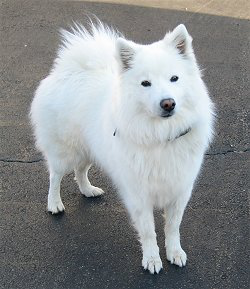

In [136]:
#  Run an prediction on the endpoint
import torchvision as tv
#sample = tv.datasets.ImageFolder(root="dogImages/train", transform=tv.transforms.ToTensor())
from PIL import Image
# = next(iter(sample))[0]# Your code to load and preprocess image to send to endpoint for prediction
with open("dogImages/train/006.American_eskimo_dog/American_eskimo_dog_00395.jpg", "rb") as f:
    payload = f.read()

import io
Image.open(io.BytesIO(payload))




In [137]:
response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request a677f55d-eb5c-47b6-8c2a-6d1e07f588c8.

In [ ]:
response

In [ ]:
#Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()